<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Assignment_3_2_OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load a reduced dataset for transfer learning that:
    1. Only contains the classes „ship“ and „truck“
    2. Only contains the first 50 images of the original dataset that are either „ship“ or „truck“.
2. Apply transfer learning by loading the model that was trained on the eight CIFAR classes
(Notebook 1) and do the following experiments:
    1. Re-initalize the last fully connected layer to predict on two classes.
    2. Train on the 50 training images (as on the last slide) with the model using two different
approaches:
        1. Fine-tune all parameters (i.e. do not freeze parameters but reduce learning rate).
        2. Freeze all parameters expect the ones from the last fc-layer.
    3. Calculate the accuracy for both approaches on 50 test images.
3. Do the same as in step 2 but use the pre-trained network resnet18 from the torch vision library.
Compare the results.
4. Resnet18 was pre-trained on the image net data, which has an image resolution of 224x224.
However, Resnet18 still works on other solutions because it uses an adaptive pooling layer
before the fc-layer (see discussion here). Try to see if you can improve the results by resizing
the CIFAR images to 224x224 before passing it to the Resnet.
5. Bonus: Check how the transfer learning approach works with the pre-trained VGG16 model.

#Import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math


In [2]:
torch.backends.cudnn.enabled = True
GPU_ON = torch.cuda.is_available()
#GPU_ON = False
device = torch.device("cuda:0" if GPU_ON else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Data

In [4]:
from enum import Enum

class Target(Enum):
    Plane = 0
    Car = 1
    Bird = 2
    Cat = 3
    Deer = 4
    Dog = 5
    Frog = 6
    Horse = 7
    Ship = 8
    Truck = 9

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
targets = [Target.Ship.value, Target.Truck.value]

targetDict = {}
for i in range(len(targets)):
  targetDict[targets[i]] = i

targetDict

{8: 0, 9: 1}

In [6]:
class NewCifar(Dataset):

    def __init__(self, orignalCifar, targets, amount = -1):
        self.newCifar = []
       
        hits = 0
        for i in range(len(orignalCifar)):
          if amount > 0  and hits >= amount:
            break
          else:
            targetLabel = orignalCifar.targets[i]
            if targetLabel in targets:
              orignalCifar.targets[i] = targetDict[targetLabel]
              hits += 1
              self.newCifar.append(orignalCifar[i])

    def __len__(self):
        return len(self.newCifar)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.newCifar[idx]

In [7]:
def getSizeOfTarget(target, data):
  count = 0
  for item in data:
    if item[1] == targetDict[target]:
      count += 1
  return count

def printSizeOfClasses(classes, targets, data):
  for i in targets:
    print("%s: %d" % (classes[i], getSizeOfTarget(i, data)))

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform), targets, 50) #only load first 50 for training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform), targets)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

print("-------------------------------------------------")
print("Training data:")
printSizeOfClasses(classes, targets, trainset)
print("-------------------------------------------------")
print("Test data:")
printSizeOfClasses(classes, targets, testset)
print("-------------------------------------------------")
print("Train size: %s" % len(trainset))
print("Test size: %s" % len(testset))

Files already downloaded and verified
Files already downloaded and verified
-------------------------------------------------
Training data:
ship: 21
truck: 29
-------------------------------------------------
Test data:
ship: 1000
truck: 1000
-------------------------------------------------
Train size: 50
Test size: 2000


#Data

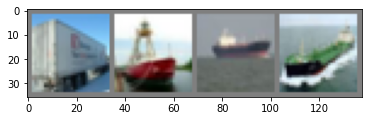

truck  ship  ship  ship


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[targets[labels[j]]] for j in range(4)))

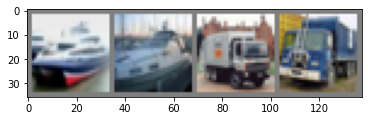

 ship  ship truck truck


In [10]:
# get some testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[targets[labels[j]]] for j in range(4)))

#Load Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)   # has to be 8

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

criterion = nn.CrossEntropyLoss()
global optimizer

def loadNet(freeze = False, learnRate=0.001, momentum=0.9):
    net = Net()

    PATH = '/content/drive/My Drive/Public/KILAB/A3/CIFAR8_NET.pth'
    net.load_state_dict(torch.load(PATH))

    for param in net.parameters():
      param.requires_grad = not freeze
        
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = net.fc3.in_features
    net.fc3 = nn.Linear(num_ftrs, len(targets)) # change to correct amount of targets

    global criterion
    global optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), learnRate, momentum)

    if GPU_ON:
      net.cuda()
 
    return net

#Utils

In [12]:
def showTestPerClass(net, silent=False, testloader=testloader):
    class_correct = list(0. for i in range(len(targets)))
    class_total = list(0. for i in range(len(targets)))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if GPU_ON:
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            _, pedictions = torch.max(outputs, 1)
            
            for i in range(len(images)):
                label = labels[i].item()
                prediction = pedictions[i].item()
                if label == prediction:
                    class_correct[label] += 1
                class_total[label] += 1

    if not silent:
      print("class_correct: %s" % class_correct)
      print("class_total: %s" % class_total)
      for target in targets:
          print('Accuracy of %5s : %2d %%' % (
              classes[target], 100 * class_correct[targetDict[target]] / class_total[targetDict[target]]))
      print('Total accuracy: {:3.2f}%'.format(100 * (sum(class_correct) / sum(class_total))))
    else:
      return (sum(class_correct) / sum(class_total))


train_counter = []
train_losses = []

def createTrainingLossPlot():
    temp = plt.figure()
    plt.legend(['Train Loss'], loc='upper right')
    plt.xlabel("Iterations")
    plt.ylabel('Loss')
    plt.plot(train_counter, train_losses, color='blue')
    plt.close()
    return temp

#Train

In [13]:
def train(net, epochs, silent=True, trainset=trainset, trainloader=trainloader, testloader=testloader):
  duration = time.time()
  global criterion
  global optimizer
  global train_counter
  global train_losses
  train_counter = []
  train_losses = []

  bestNetWeights = copy.deepcopy(net.state_dict())
  bestAcc = 0.0
  for epoch in range(epochs):  # loop over the dataset multiple times
      net.train()
      logInterval = math.floor(len(trainset) / 4)
      currentCount = 0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          if GPU_ON:
            inputs = inputs.cuda()
            labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

          train_losses.append(loss.item())
          train_counter.append((epoch * len(trainset)) + currentCount)

          currentCount += len(inputs)
          if i % logInterval == 0 and not silent:
            print('Train Epoch: {:4d} [{:2d}/{} ({:3.0f}%)]  Loss: {:.6f}'.format(
              epoch + 1, currentCount, len(trainset),
              100. * (i + 1) / len(trainloader), loss.item()))

      epochAcc = showTestPerClass(net, True, testloader)
      if (epochAcc > bestAcc):
        bestAcc = epochAcc
        bestNetWeights = copy.deepcopy(net.state_dict())

  if not silent:
    print('Finished Training')
  print("------------------------------------------------")
  print('Best accuracy: {:3.2f}%'.format(100. * bestAcc))
  print("------------------------------------------------")

  duration = time.time() - duration
  print("--- " + ("GPU" if GPU_ON else "CPU") + ": %s seconds ---" % (duration))

  # load best model weights
  net.load_state_dict(bestNetWeights) 
  return net

#2.ii.a Do not freeze parameters but reduce learnin rate

------------------------------------------------
Best accuracy: 49.35%
------------------------------------------------
--- GPU: 2.81108021736145 seconds ---


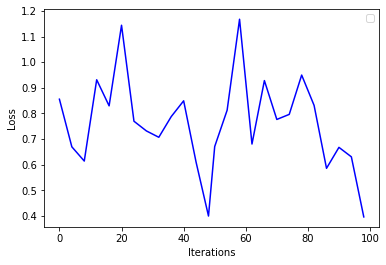

In [14]:
net = loadNet(False, 0.000001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 49.00%
------------------------------------------------
--- GPU: 2.860304832458496 seconds ---


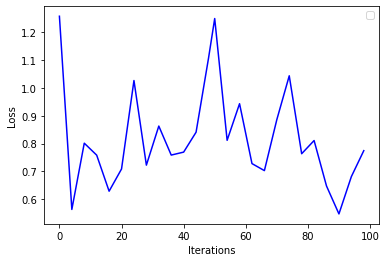

In [15]:
net = loadNet(False, 0.00001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 50.10%
------------------------------------------------
--- GPU: 2.9459686279296875 seconds ---


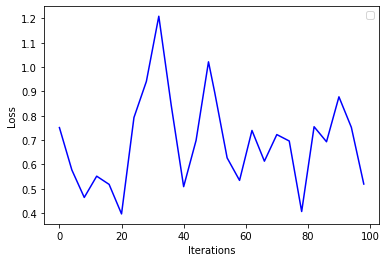

In [16]:
net = loadNet(False, 0.0001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 61.35%
------------------------------------------------
--- GPU: 2.9238955974578857 seconds ---


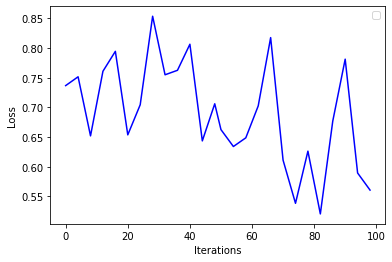

In [17]:
net = loadNet(False, 0.001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 74.75%
------------------------------------------------
--- GPU: 2.9283556938171387 seconds ---


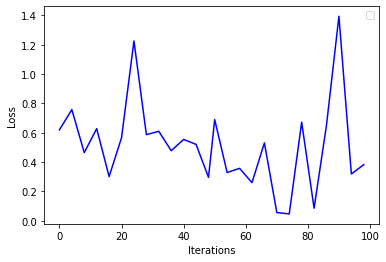

In [18]:
net = loadNet(False, 0.01) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 72.05%
------------------------------------------------
--- GPU: 2.918781280517578 seconds ---


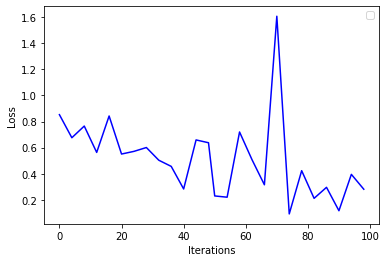

In [19]:
net = loadNet(False, 0.01) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 79.10%
------------------------------------------------
--- GPU: 29.649144887924194 seconds ---


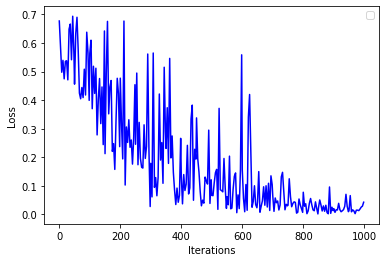

In [20]:
net = loadNet(False, 0.001) # default parameters
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

------------------------------------------------
Best accuracy: 80.75%
------------------------------------------------
--- GPU: 291.8930685520172 seconds ---


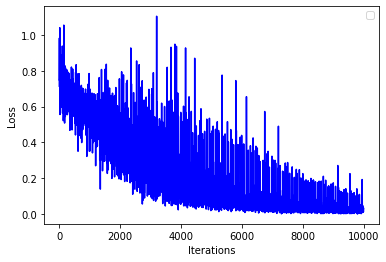

In [21]:
net = loadNet(False, 0.0001) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(False, 0.001) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(False, 0.01) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

#2.ii.b Freeze all parameters except the ones from the last fc-layer

In [ ]:
net = loadNet(True, 0.00001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.0001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.01) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.1) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.001) # default parameters
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.0001) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.001) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadNet(True, 0.01) # default parameters
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

#3. Pre-trained network resnet18 from the torch vision library

In [ ]:
def loadResNet18(freeze = False, learnRate=0.001, momentum=0.9):
  resnet18 = torchvision.models.resnet18(pretrained=True)

  for param in resnet18.parameters():
    param.requires_grad = not freeze
          
  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = resnet18.fc.in_features
  resnet18.fc = nn.Linear(num_ftrs, len(targets)) # change to correct amount of targets

  global criterion
  global optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), learnRate, momentum)

  if GPU_ON:
    resnet18.cuda()

  return resnet18

In [ ]:
net = loadResNet18(False, 0.001) # default parameters
train(net, 2)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(False, 0.001)
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.00001)
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.0001)
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.001)
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.01)
train(net, 20)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.001)
train(net, 200)
#showTestPerClass(net)

createTrainingLossPlot()

#4. ResNet18 with CIFAR10 resized from 32x32 to 224x224

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset224 = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform), targets, 50) #only load first 50 for training
trainloader224 = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testset224 = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform), targets)
testloader224 = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [ ]:
net = loadResNet18(False, 0.0001)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(False, 0.001)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(False, 0.01)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.0001)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.001)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()

In [ ]:
net = loadResNet18(True, 0.01)
train(net, 200, trainset=trainset224, trainloader=trainloader224, testloader=testloader224)
#showTestPerClass(net)

createTrainingLossPlot()